## Clustering tutorial

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import dataload as epi
import scib_metrics
from scib_metrics.benchmark import Benchmarker
import scvi
import importlib
import epipack as epk
from vae_vamp_gmm import VAE_COMMON

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be remov

In [2]:
data = sc.read_h5ad("../../data/clustering/cerebrum_batch_1.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
data.X = data.raw.X

In [4]:
import sklearn.preprocessing as sp

min_cells = int(data.shape[0] * 0.01)
sc.pp.filter_genes(data, min_cells=min_cells)
#data.X = sp.binarize(data.X)

In [5]:
data

AnnData object with n_obs × n_vars = 20680 × 40174
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample_name', 'donor_id', 'day_of_pregnancy', 'sex', 'tissue', 'batch', 'total', 'total_deduplicated', 'total_deduplicated_peaks', 'total_deduplicated_tss', 'frip', 'frit', 'x_chrom_window_counts', 'y_chrom_window_counts', 'autosome_window_counts', 'blacklist_fraction', 'RNA_snn_res.0.3', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'tissue_umap_1', 'tissue_umap_2', 'cell_type', 'peaks_snn_res.0.8'
    var: 'count', 'percentile', 'n_cells'
    uns: 'neighbors'
    obsm: 'X_lsi', 'X_tsne', 'X_umap'
    varm: 'LSI'
    obsp: 'distances'

In [6]:
pretrain_peak_model = epk.ml.Peak_Model(count_enhancer=data.X.todense(), z_dim=50, batch_size=512, layer_num=2, region_factor=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Model intialization completed.


In [7]:
pretrain_peak_model.train_model(nepochs=200)
z = pretrain_peak_model.get_z()
data.obsm['epipack_z_bce'] = z.detach().cpu().numpy()

Epochs: 100%|██████████| 200/200 [10:10<00:00,  3.05s/it, loss_val=741]


/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


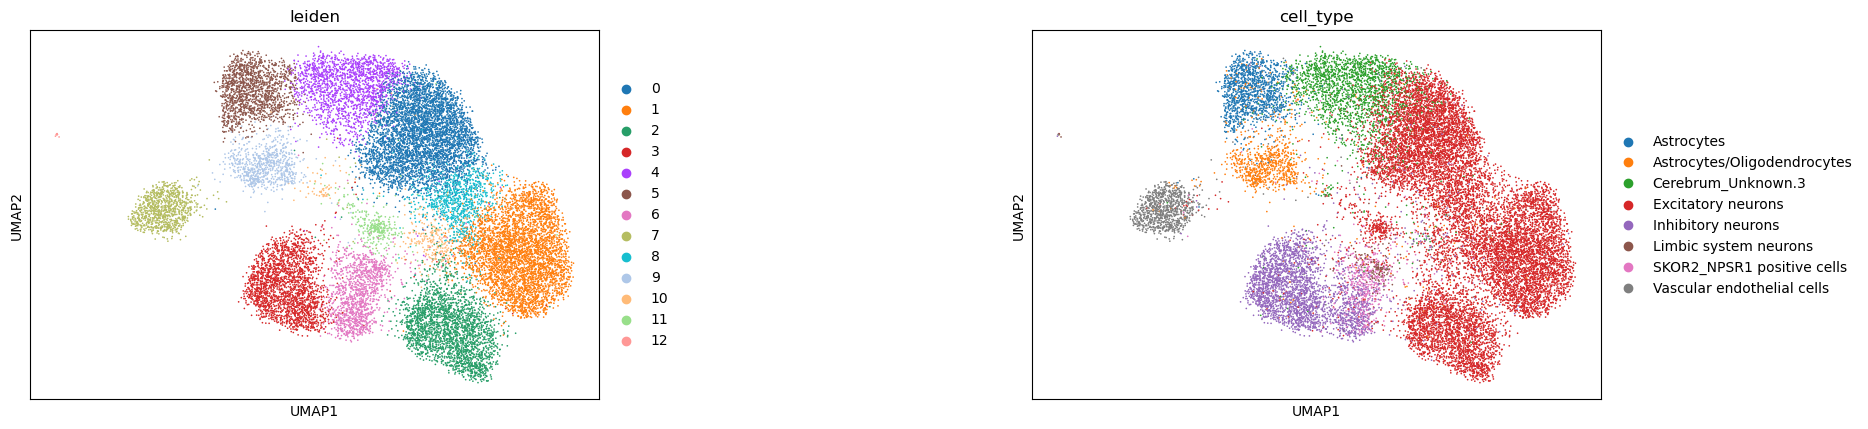

In [28]:
sc.pp.neighbors(data, n_neighbors=10, use_rep='epipack_z_bce')
sc.tl.umap(data)
sc.tl.leiden(data, resolution=1)
sc.pl.umap(data, color=['leiden','cell_type'], ncols=2, wspace=0.6)

In [9]:
celltype = pd.read_csv("../../data/clustering/cerebrum_batch_1_celltype.csv")

In [10]:
data.obs['cell_type'] = list(celltype.x)

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


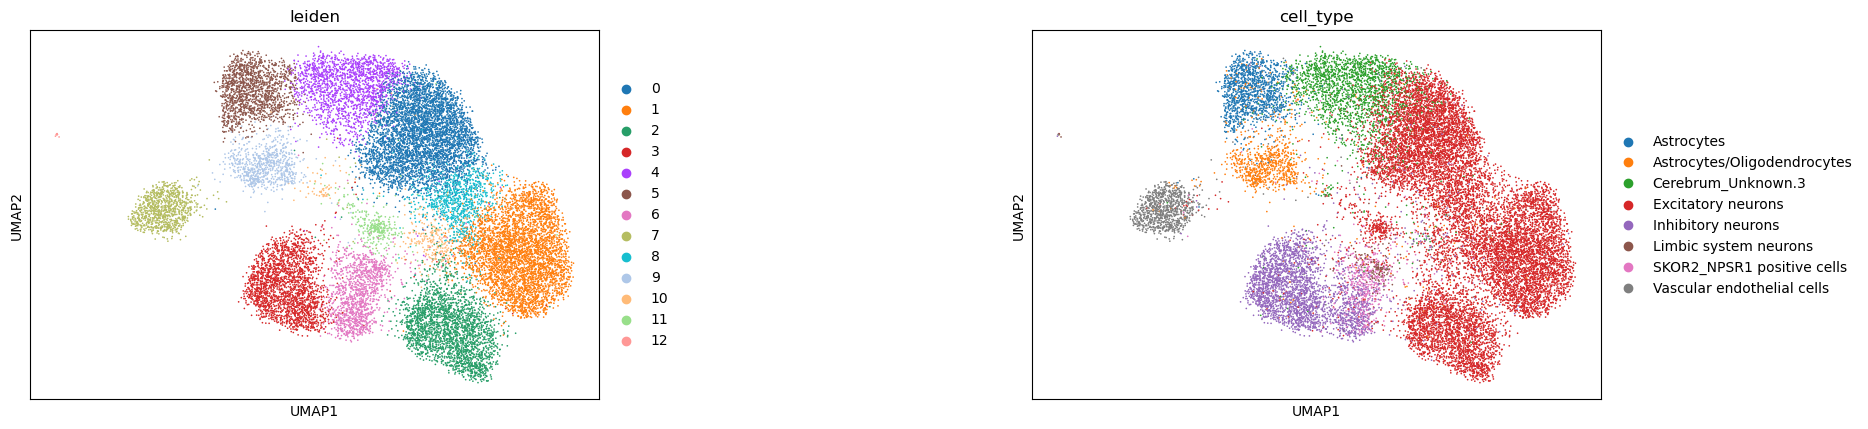

In [11]:
sc.pl.umap(data, color=['leiden','cell_type'], ncols=2, wspace=0.6)

In [30]:
scib_metrics.nmi_ari_cluster_labels_leiden(data.obsp['connectivities'], data.obs['cell_type'], optimize_resolution=True, resolution=1.0, n_jobs=1)

{'nmi': 0.5841662268804542, 'ari': 0.4483450889309464}

In [31]:
scib_metrics.silhouette_label(data.obsm['epipack_z_bce'], data.obs['cell_type'], rescale=True, chunk_size=256)

0.5194529201835394

In [32]:
scib_metrics.clisi_knn(data.obsp['distances'], data.obs['cell_type'], perplexity=None, scale=True)

0.9999999829701015

### peakvi

In [12]:
data.obs['dataset'] = data.obs['batch']

In [13]:
peakvi_test = data.copy()

In [14]:
#min_cells = int(peakvi_test.shape[0] * 0.01)
#sc.pp.filter_genes(peakvi_test, min_cells=min_cells)
scvi.model.PEAKVI.setup_anndata(peakvi_test)
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 122/500:  24%|██▍       | 122/500 [09:57<30:50,  4.89s/it, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=8.02e+7] 
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 5341.286. Signaling Trainer to stop.


In [15]:
PEAKVI_LATENT_KEY = "X_peakvi"

latent = pvi.get_latent_representation()
data.obsm[PEAKVI_LATENT_KEY] = latent

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


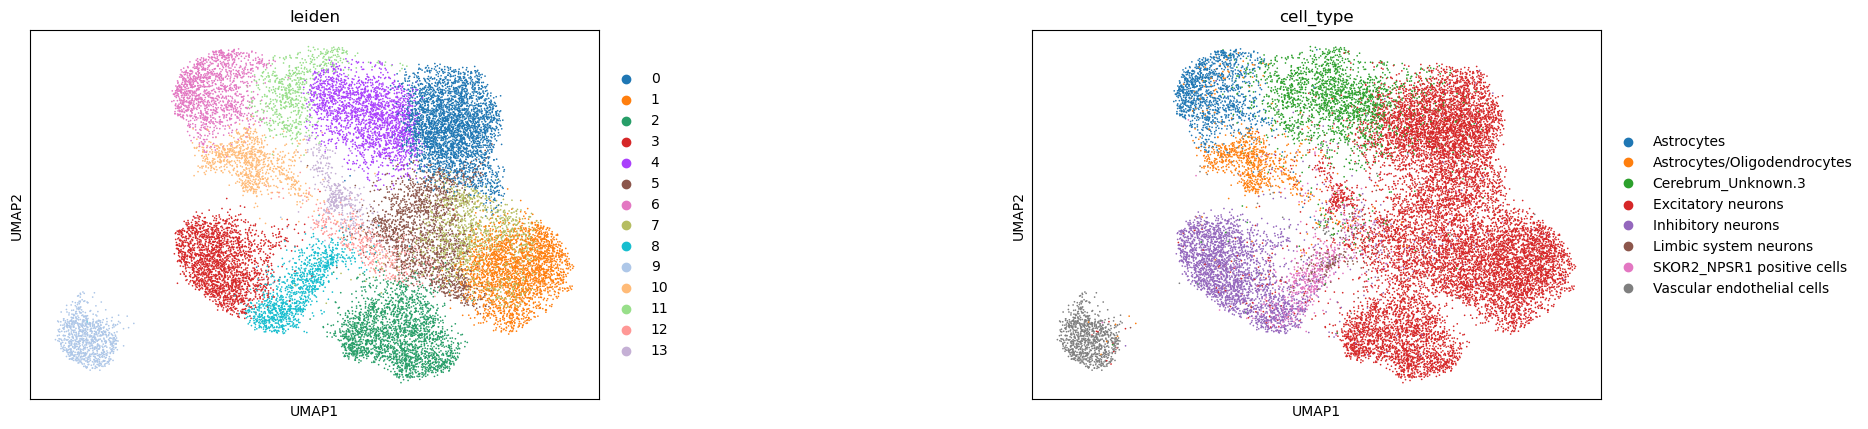

In [16]:
sc.pp.neighbors(data, n_neighbors=10, use_rep='X_peakvi')
sc.tl.umap(data)
sc.tl.leiden(data, resolution=1)
sc.pl.umap(data, color=['leiden','cell_type'], ncols=2, wspace=0.6)

In [17]:
biocon = scib_metrics.benchmark.BioConservation(isolated_labels=True, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=False, silhouette_label=True, clisi_knn=True)

In [18]:
data

AnnData object with n_obs × n_vars = 20680 × 40174
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample_name', 'donor_id', 'day_of_pregnancy', 'sex', 'tissue', 'batch', 'total', 'total_deduplicated', 'total_deduplicated_peaks', 'total_deduplicated_tss', 'frip', 'frit', 'x_chrom_window_counts', 'y_chrom_window_counts', 'autosome_window_counts', 'blacklist_fraction', 'RNA_snn_res.0.3', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'tissue_umap_1', 'tissue_umap_2', 'cell_type', 'peaks_snn_res.0.8', 'leiden', 'dataset'
    var: 'count', 'percentile', 'n_cells'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_lsi', 'X_tsne', 'X_umap', 'epipack_z_bce', 'X_peakvi'
    varm: 'LSI'
    obsp: 'distances', 'connectivities'

In [27]:
scib_metrics.nmi_ari_cluster_labels_leiden(data.obsp['connectivities'], data.obs['cell_type'], optimize_resolution=True, resolution=1.5, n_jobs=1)

{'nmi': 0.5750130693628137, 'ari': 0.32586283762289403}

In [33]:
scib_metrics.silhouette_label(data.obsm['X_peakvi'], data.obs['cell_type'], rescale=True, chunk_size=256)

0.5407780930399895

### scbasset

In [43]:
scbassset_test = data.copy()
min_cells = int(scbassset_test.shape[0] * 0.05)
sc.pp.filter_genes(scbassset_test, min_cells=min_cells)

In [44]:
chr = []
start = []
end = []
for i in scbassset_test.var_names:
    i = i.split('-')
    chr.append(i[0])
    start.append(int(i[1]))
    end.append(int(i[2]))

In [45]:
scbassset_test.var['chr'] = chr
scbassset_test.var['start'] = start
scbassset_test.var['end'] = end

scvi.data.add_dna_sequence(
    scbassset_test,
    chr_var_key="chr",
    start_var_key="start",
    end_var_key="end",
    genome_name="hg38",
    genome_dir="data",
)

Working...: 100%|██████████| 23/23 [00:01<00:00, 14.39it/s]


In [46]:
bdata = scbassset_test.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(
    bdata, layer="binary", dna_code_key="dna_code"
)

INFO     Using column names from columns of adata.obsm['dna_code']                                                 


In [47]:
model = scvi.external.SCBASSET(bdata)

In [48]:
model.train(precision=16)

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/lightning/fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 1000/1000: 100%|██████████| 1000/1000 [36:04<00:00,  2.15s/it, v_num=1, train_loss_step=0.271, train_loss_epoch=0.266]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [36:04<00:00,  2.16s/it, v_num=1, train_loss_step=0.271, train_loss_epoch=0.266]


In [50]:
latent = model.get_latent_representation()
data.obsm["X_scbasset"] = latent

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


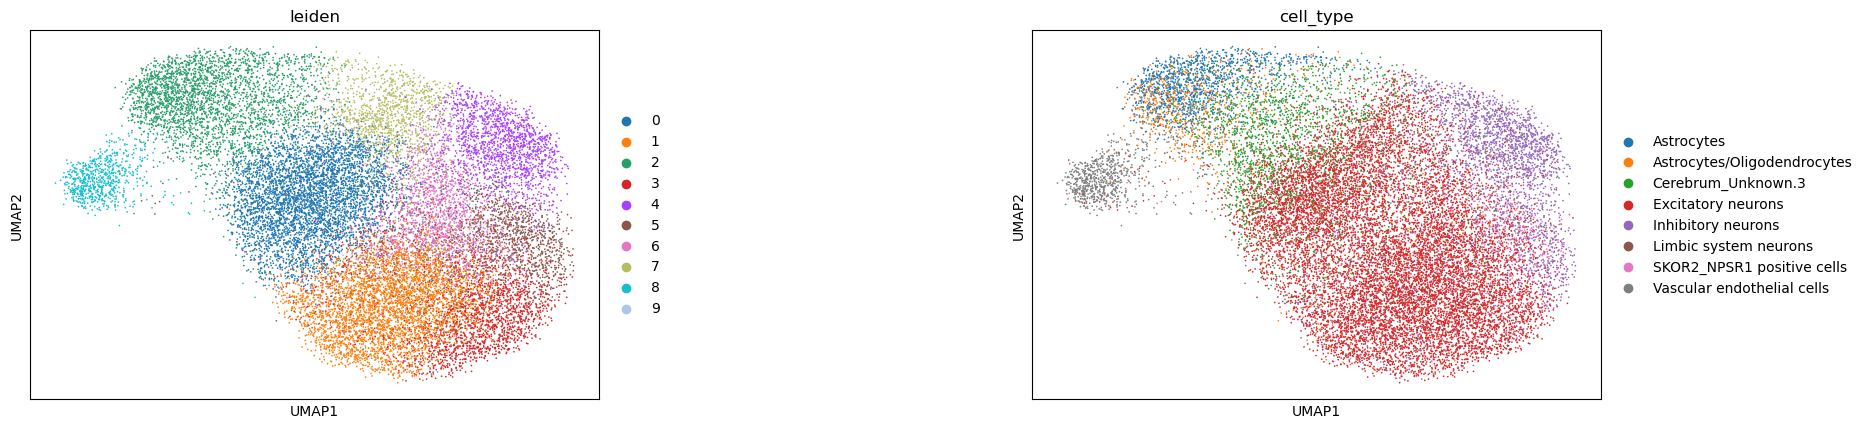

In [51]:
sc.pp.neighbors(data, n_neighbors=10, use_rep='X_scbasset')
sc.tl.umap(data)
sc.tl.leiden(data, resolution=1)
sc.pl.umap(data, color=['leiden','cell_type'], ncols=2, wspace=0.6)

### lsi

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


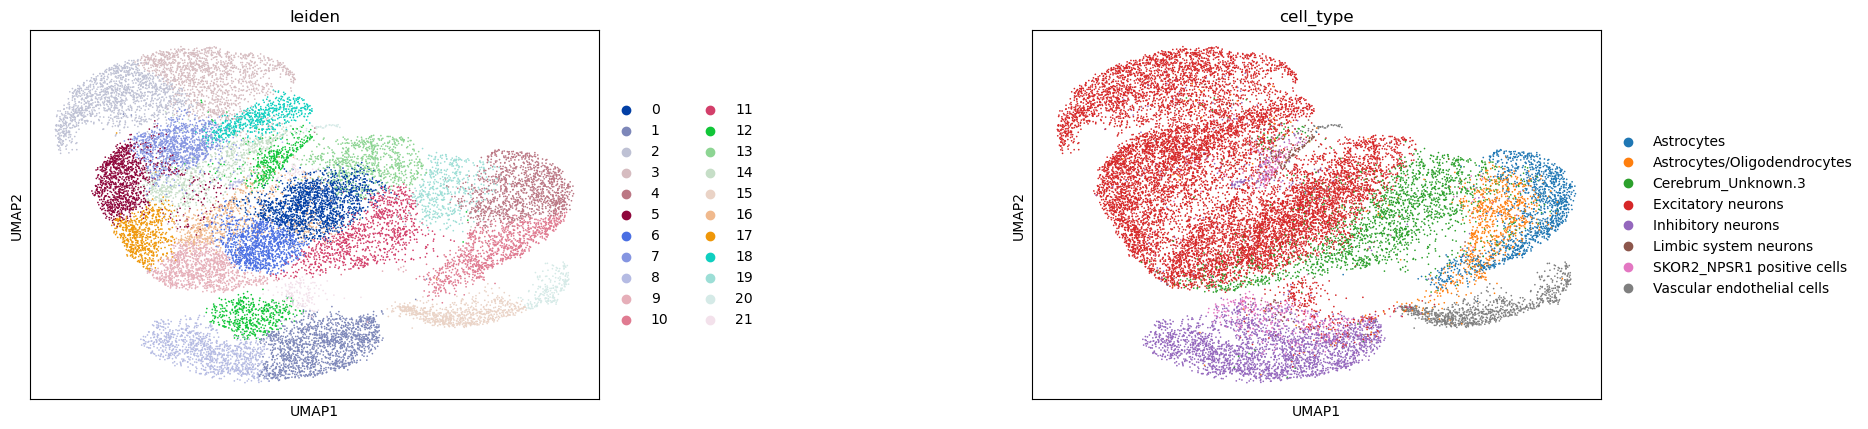

In [52]:
sc.pp.neighbors(data, n_neighbors=10, use_rep='X_lsi')
sc.tl.umap(data)
sc.tl.leiden(data, resolution=1)
sc.pl.umap(data, color=['leiden','cell_type'], ncols=2, wspace=0.6)

In [53]:
scib_metrics.nmi_ari_cluster_labels_leiden(data.obsp['connectivities'], data.obs['cell_type'], optimize_resolution=True, resolution=1.5, n_jobs=1)

{'nmi': 0.502081417500375, 'ari': 0.2452450043638394}

In [54]:
scib_metrics.silhouette_label(data.obsm['X_lsi'], data.obs['cell_type'], rescale=True, chunk_size=256)

0.46758614107966423

In [55]:
data

AnnData object with n_obs × n_vars = 20680 × 40174
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample_name', 'donor_id', 'day_of_pregnancy', 'sex', 'tissue', 'batch', 'total', 'total_deduplicated', 'total_deduplicated_peaks', 'total_deduplicated_tss', 'frip', 'frit', 'x_chrom_window_counts', 'y_chrom_window_counts', 'autosome_window_counts', 'blacklist_fraction', 'RNA_snn_res.0.3', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'tissue_umap_1', 'tissue_umap_2', 'cell_type', 'peaks_snn_res.0.8', 'leiden', 'dataset'
    var: 'count', 'percentile', 'n_cells'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_type_colors', 'pca'
    obsm: 'X_lsi', 'X_tsne', 'X_umap', 'epipack_z_bce', 'X_peakvi', 'X_pca', 'X_scbasset'
    varm: 'LSI', 'PCs'
    obsp: 'distances', 'connectivities'

In [56]:
data.write_h5ad("../../data/clustering/cerebrum_result_1028.h5ad")

In [2]:
data = sc.read_h5ad("../../data/clustering/cerebrum_result_1028.h5ad")

In [3]:
sc.pp.neighbors(data, n_neighbors=10, use_rep='epipack_z_bce')

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:358: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  nn_descent_internal_low_memory_parallel(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:358: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  nn_descent_internal_low_memory_parallel(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:370: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  nn_descent_internal_high_memory_parallel(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:370: NumbaPendingDeprecationWarning: The 'old_style' e

In [4]:
data

AnnData object with n_obs × n_vars = 20680 × 40174
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample_name', 'donor_id', 'day_of_pregnancy', 'sex', 'tissue', 'batch', 'total', 'total_deduplicated', 'total_deduplicated_peaks', 'total_deduplicated_tss', 'frip', 'frit', 'x_chrom_window_counts', 'y_chrom_window_counts', 'autosome_window_counts', 'blacklist_fraction', 'RNA_snn_res.0.3', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'tissue_umap_1', 'tissue_umap_2', 'cell_type', 'peaks_snn_res.0.8', 'leiden', 'dataset'
    var: 'count', 'percentile', 'n_cells'
    uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_peakvi', 'X_scbasset', 'X_tsne', 'X_umap', 'epipack_z_bce'
    varm: 'LSI', 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
from sklearn.neighbors import NearestNeighbors

In [12]:
data_c0 = data[data.obs['leiden'] == '0']

In [15]:
data_c0.obsp['distances']

<4444x4444 sparse matrix of type '<class 'numpy.float64'>'
	with 36113 stored elements in Compressed Sparse Row format>

In [16]:
sc.pp.neighbors(data_c0, n_neighbors=10, use_rep='epipack_z_bce')

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/numba/core/types/functions.py:310: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  if (utils.use_new_style_errors() and not
